# 빅데이터 분석 특강 (1주차) 3월7일 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Big Data Analysis, 정규방정식, 벡터 미분, 매트릭스 미분]

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 로드맵 

`-` 오늘수업할내용: 단순선형회귀 

`-` 단순선형회귀를 배우는 이유? 

- 우리가 배우고싶은것: 심층신경망(DNN) $\to$ 합성곱신경망(CNN) $\to$ 적대적생성신경망(GAN) 
- 심층신경망을 바로 이해하기 어려움 
- 다음의 과정으로 이해해야함: (선형대수학 $\to$) 회귀분석 $\to$ 로지스틱회귀분석 $\to$ 심층신경망 

### 선형회귀 

`-` 상황극
- 나는 동네에 커피점을 하나 차렸음. 
- 장사를 하다보니까 날이 더울수록 아이스아메리카노의 판매량이 증가한다는 사실을 깨달았다. 
- 일기예보는 미리 나와있으니까 그 정보를 잘 이용하면 '온도 -> 아이스아메리카노 판매량 예측' 이 가능할것 같다. (내가 앞으로 얼마나 벌지 예측가능) 

`-` 가짜자료 생성 

In [3]:
import matplotlib.pyplot as plt 
import tensorflow as tf 

온도 ${\bf x}$가 아래와 같다고 하자. 

In [5]:
x=tf.constant([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]) # 기온 
x

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4],
      dtype=float32)>

아이스아메리카노의 판매량 ${\bf y}$이 아래와 같다고 하자. (판매량은 정수로 나오겠지만 편의상 소수점도 가능하다고 생각하자) 

$${\bf y} \approx 10.2 +2.2 {\bf x}$$ 

- 여기에서 10.2, 2.2 의 숫자는 제가 임의로 정한것임 
- 식의의미: 온도가 0일때 10.2잔정도 팔림 + 온도가 1도 증가하면 2.2잔정도 더 팔림 
- 물결의의미: 현실반영. 세상은 꼭 수식대로 정확하게 이루어지지 않음. 

In [6]:
tf.random.set_seed(43052)
epsilon=tf.random.normal([10])
y=10.2 + 2.2*x + epsilon
y

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([55.418365, 58.194283, 61.230827, 62.312557, 63.107002, 63.69569 ,
       67.247055, 71.4365  , 73.1013  , 77.84988 ], dtype=float32)>

`-` 우리는 아래와 같은 자료를 모았다고 생각하자.  

In [7]:
tf.transpose(tf.concat([[x],[y]],0))

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[20.1     , 55.418365],
       [22.2     , 58.194283],
       [22.7     , 61.230827],
       [23.3     , 62.312557],
       [24.4     , 63.107002],
       [25.1     , 63.69569 ],
       [26.2     , 67.247055],
       [27.3     , 71.4365  ],
       [28.4     , 73.1013  ],
       [30.4     , 77.84988 ]], dtype=float32)>

`-` 그려보자. 

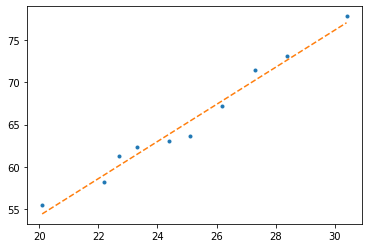

In [8]:
plt.plot(x,y,'.') # 파란점, 관측한 데이터 
plt.plot(x,10.2 + 2.2*x, '--')  # 주황색점선, 세상의 법칙 

`-` 우리의 목표: 파란색점 $\to$ 주황색점선을 추론 // 데이터를 바탕으로 세상의 법칙을 추론 

`-` 아이디어: 데이터를 보니까 $x$와 $y$가 선형의 관계에 있는듯 보인다. 즉 모든 $i=1,2,\dots, 10$에 대하여 아래를 만족하는 적당한 a,b (혹은 $\beta_0,\beta_1$) 가 존재할것 같다. 
- $y_{i} \approx ax_{i}+b$
- $y_{i} \approx \beta_1 x_{i}+\beta_0$ 

`-` 어림짐작으로 $a,b$를 알아내보자. 

데이터를 살펴보자. 

In [9]:
tf.transpose(tf.concat([[x],[y]],0))

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[20.1     , 55.418365],
       [22.2     , 58.194283],
       [22.7     , 61.230827],
       [23.3     , 62.312557],
       [24.4     , 63.107002],
       [25.1     , 63.69569 ],
       [26.2     , 67.247055],
       [27.3     , 71.4365  ],
       [28.4     , 73.1013  ],
       [30.4     , 77.84988 ]], dtype=float32)>

적당히 `왼쪽*2+15 = 오른쪽`의 관계가 성립하는것 같다. 

따라서 $a=2, b=15$ 혹은 $\beta_0=15, \beta_1=2$ 로 추론할 수 있겠다. 

`-` 누군가가 $(\beta_0,\beta_1)=(14,2)$ 이라고 주장할 수 있다. (어차피 지금은 감각으로 추론하는 과정이니까) 

`-` 새로운 주장으로 인해서 $(\beta_0,\beta_1)=(15,2)$ 로 볼 수도 있고 $(\beta_0,\beta_1)=(14,2)$ 로 볼 수도 있다. 이중에서 어떠한 추정치가 좋은지 판단할 수 있을까? 
- 후보1: $(\beta_0,\beta_1)=(15,2)$ 
- 후보2: $(\beta_0,\beta_1)=(14,2)$

`-` 가능한 $y_i \approx \beta_0 + \beta_1 x_i$ 이 되도록 만드는 $(\beta_0,\beta_1)$ 이 좋을 것이다. $\to$ 후보 1,2를 비교해보자. 

(관찰에 의한 비교) 

후보1에 대해서 $i=1,2$를 넣고 관찰하여 보자. 

In [11]:
20.1 * 2 + 15 , 55.418365 # i=1 

(55.2, 55.418365)

In [12]:
22.2 * 2 + 15 , 58.194283 # i=2

(59.4, 58.194283)

후보2에 대하여 $i=1,2$를 넣고 관찰하여 보자. 

In [13]:
20.1 * 2 + 14 , 55.418365 # i=1 

(54.2, 55.418365)

In [14]:
22.2 * 2 + 14 , 58.194283 # i=2

(58.4, 58.194283)

$i=1$인 경우에는 후보1이 더 잘맞는것 같은데 $i=2$인 경우는 후보2가 더 잘맞는것 같다. 

(좀 더 체계적인 비교) 

$i=1,2,3, \dots, 10$ 에서 후보1과 후보2중 어떤것이 더 좋은지 비교하는 체계적인 방법을 생각해보자. 

후보 1,2에 대하여 $\sum_{i=1}^{10} (y_i -\beta_0 -\beta_1 x_i)^2$를 계산하여 비교해보자. 

In [15]:
sum1=0 
for i in range(10):
    sum1=sum1+(y[i]-15-2*x[i])**2 

In [16]:
sum2=0 
for i in range(10):
    sum2=sum2+(y[i]-14-2*x[i])**2 

In [17]:
sum1,sum2

(<tf.Tensor: shape=(), dtype=float32, numpy=14.734169>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.521088>)

후보1이 더 $\sum_{i=1}^{10} (y_i -\beta_0 -\beta_1 x_i)^2$의 값이 작다. 

후보1이 종합적으로 후보2에 비하여 좋다. 이 과정을 무한번 반복하면 최적의 추정치를 찾을 수 있다. 

`-` 그런데 이 알고리즘은 현실적으로 구현이 불가능하다. 
- 무한번 계산하기도 힘들고,
- 언제 멈출지도 애매함

`-` 수학을 이용해서 좀 더 체계적으로 찾아보자. 결국 아래식을 가장 작게 만드는 $\beta_0,\beta_1$을 찾으면 된다. 

$\sum_{i=1}^{10} (y_i -\beta_0 -\beta_1 x_i)^2$

그런데 결국 $\beta_0, \beta_1$에 대한 이차식인데 이 식을 최소화하는 $\beta_0,\beta_1$을 구하기 위해서는 아래를 연립하여 풀면된다. 

$\begin{cases}
\frac{\partial}{\partial \beta_0}\sum_{i=1}^{10} (y_i -\beta_0 -\beta_1 x_i)^2=0 \dots (1)\\ 
\frac{\partial}{\partial \beta_1}\sum_{i=1}^{10} (y_i -\beta_0 -\beta_1 x_i)^2=0 \dots (2)
\end{cases}$

`-` 풀어보자. 

$\begin{cases}
\sum_{i=1}^{10} -2(y_i -\beta_0 -\beta_1 x_i)=0 \\ 
\sum_{i=1}^{10} -2x_i(y_i -\beta_0 -\beta_1 x_i)=0
\end{cases}$

---

**정규방정식**

(1)

$\leftrightarrow \sum_{i=1}^{n} -2(y_i - \beta_0 - \beta_1 x_i) \rightarrow \sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i) = 0 \leftrightarrow \sum y_i - n \beta_0 - \beta_1 \sum x_i = 0$

$\leftrightarrow \beta_0 = \frac{1}{n} \sum y_i - \beta_1 \frac{1}{n}\sum x_i \leftrightarrow \beta_0 = \bar{y} - \beta_1 \bar{x}$

(2)

$\leftrightarrow \sum^{n}_{i=1} x_i (y_i - \beta_0 - \beta_1 x_i) = 0 \leftrightarrow \sum x_i y_i - \beta_0 n \bar{x} - \beta_1 \sum x_{i}^{2} = 0$

$\sum x_i y_i - ( \bar{y} - \beta_1 \bar{x}) n \bar{x} - \beta_1 \sum x_{i}^{2} = 0$

$\leftrightarrow \beta_1 (n(\bar{x})^2 - \sum x_{i}^{2}) + \sum x_i y_i - \bar{y} n \bar{x} = 0$

$\beta_1 = \frac{\sum x_i y_i - n \bar{x} \bar{y}}{\sum x_{i}^{2} - n (\bar{x})^2} = \frac{\beta_1분자}{\beta_1 분모}$

(예비학습)

$S_{xy} = \sum^{n}_{i=1} (x_i - \bar{x} ) (y_i - \bar{y} ) = \sum^{n}_{i=1} (x_i - \bar{x}) y_i$

pf. $\sum^{x}_{i=1}(x_i - \bar{x}) \bar{y} = 0$ 을 보이면 된다.

$LHS(Left-Hand Side) = \sum^{n}_{i=1} x_i \bar{y} - n \bar{x} \bar{y} = \bar{y} \sum^{n}_{i=1} x_i - n \bar{x}\bar{y} = 0$

($\beta_1$의 분자 = $S_{xy}$임을 보이자)

$S_{xy} = \sum^{n}_{i=1}(x_i - \bar{x})y_i = \sum^{n}_{i=1} x_i y_i - \bar{x} \sum^{n}_{i=1} y_i = \sum x_i y_i - \bar{x} n \bar{y} = \beta_1$의 분자

($\beta_1$의 분모 = $S_{xx}$임을 보이자)

$S_{xx} = \sum^{n}_{i=1}(x_i - \bar{x})^2 = \sum ( x_{i}^{2} - 2 x_i \bar{x} + (\bar{x})^2) = \sum x_{i}^{2} - 2 n \bar{x} \bar{x} + n (\bar{x})^2 = \sum x_{i}^{2} - n(\bar{x})^2 = \beta_1$의 분모

---

정리하면 

$$\hat{\beta}_0= \bar{y}-\hat{\beta}_1 \bar{x}$$

$$\hat{\beta}_1= \frac{S_{xy}}{S_{xx}}=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

`-` 따라서 최적의 추정치 $(\hat{\beta}_0,\hat{\beta}_1)$를 이용한 추세선을 아래와 같이 계산할 수 있음.

In [18]:
Sxx= sum((x-sum(x)/10)**2)
Sxx

<tf.Tensor: shape=(), dtype=float32, numpy=87.848976>

In [19]:
Sxy=  sum((x-sum(x)/10)*(y-sum(y)/10))
Sxy

<tf.Tensor: shape=(), dtype=float32, numpy=194.64737>

In [20]:
beta1_estimated = Sxy/Sxx 
beta1_estimated 

<tf.Tensor: shape=(), dtype=float32, numpy=2.2157044>

In [21]:
beta0_estimated = sum(y)/10 - beta1_estimated * sum(x)/10 
beta0_estimated

<tf.Tensor: shape=(), dtype=float32, numpy=9.944572>

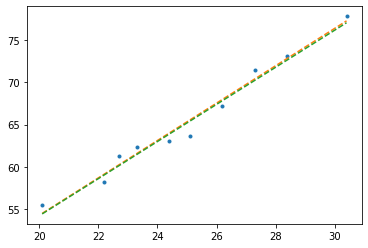

In [22]:
plt.plot(x,y,'.')
plt.plot(x,beta0_estimated + beta1_estimated * x, '--') # 주황색선: 세상의 법칙을 추정한선 
plt.plot(x,10.2 + 2.2* x, '--') # 초록색선: ture, 세상의법칙 

> Note: 샘플수가 커질수록 주황색선은 점점 초록색선으로 가까워진다. 

`-` 꽤 훌륭한 도구임. 그런데 약간의 단점이 존재한다. 

(1) 공식이 좀 복잡함.. 

(2) $x$가 여러개일 경우 확장이 어려움 

`-` 단점을 극복하기 위해서 우리가 지금까지 했던논의를 매트릭스로 바꾸어서 다시 써보자. 

`-` 모형의 매트릭스화 

우리의 모형은 아래와 같다. 

$y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \quad i=1,2,\dots,10$ 

풀어서 쓰면 

$\begin{cases}
y_1 = \beta_0 +\beta_1 x_1 + \epsilon_1 \\ 
y_2 = \beta_0 +\beta_1 x_2 + \epsilon_2 \\ 
\dots \\ 
y_{10} = \beta_0 +\beta_1 x_{10} + \epsilon_{10} 
\end{cases}$

아래와 같이 쓸 수 있다.

$\begin{bmatrix} 
y_1 \\ 
y_2 \\ 
\dots \\
y_{10} 
\end{bmatrix} 
= \begin{bmatrix} 
1 & x_1 \\ 
1 & x_2 \\ 
\dots & \dots \\
1 & x_{10} 
\end{bmatrix}\begin{bmatrix}\beta_0 \\ \beta_1 \end{bmatrix} + \begin{bmatrix} 
\epsilon_1 \\ 
\epsilon_2 \\ 
\dots \\
\epsilon_{10} 
\end{bmatrix} $

벡터와 매트릭스 형태로 정리하면 

${\bf y} = {\bf X} {\boldsymbol \beta} + \boldsymbol{\epsilon}$ 

`-` 손실함수의 매트릭스화: 우리가 최소화 하려던 손실함수는 아래와 같다. 

$loss=\sum_{i=1}^{n}(y_i-\beta_0-\beta_1x_i)^2$

이것을 벡터표현으로 하면 아래와 같다. 

$loss=\sum_{i=1}^{n}(y_i-\beta_0-\beta_1x_i)^2=({\bf y}-{\bf X}{\boldsymbol \beta})^\top({\bf y}-{\bf X}{\boldsymbol \beta})$

풀어보면 

$loss=({\bf y}-{\bf X}{\boldsymbol \beta})^\top({\bf y}-{\bf X}{\boldsymbol \beta})={\bf y}^\top {\bf y} - {\bf y}^\top {\bf X}{\boldsymbol\beta} - {\boldsymbol\beta}^\top {\bf X}^\top {\bf y} + {\boldsymbol\beta}^\top {\bf X}^\top {\bf X} {\boldsymbol\beta}$

`-` 미분하는 과정의 매트릭스화 

loss를 최소화하는 ${\boldsymbol \beta}$를 구해야하므로 loss를 ${\boldsymbol \beta}$로 미분한 식을 0이라고 놓고 풀면 된다. 

$\frac{\partial}{\partial \boldsymbol{\beta}} loss = \frac{\partial}{\partial \boldsymbol{\beta}} {\bf y}^\top {\bf y} - \frac{\partial}{\partial \boldsymbol{\beta}} {\bf y}^\top {\bf X}{\boldsymbol\beta} - \frac{\partial}{\partial \boldsymbol{\beta}} {\boldsymbol\beta}^\top {\bf X}^\top {\bf y} + \frac{\partial}{\partial \boldsymbol{\beta}} {\boldsymbol\beta}^\top {\bf X}^\top {\bf X} {\boldsymbol\beta}$ 

$= 0 - {\bf X}^\top {\bf y}- {\bf X}^\top {\bf y} + 2{\bf X}^\top {\bf X}{\boldsymbol\beta} $

따라서 $\frac{\partial}{\partial \boldsymbol{\beta}}loss=0$을 풀면 아래와 같다. 

$\boldsymbol{\hat\beta}= ({\bf X}^\top {\bf X})^{-1}{\bf X}^\top {\bf y} $

`-` 공식도 매트릭스로 표현하면: $\boldsymbol{\hat\beta}= ({\bf X}^\top {\bf X})^{-1}{\bf X}^\top {\bf y} $ <-- 외우세요 

---

**벡터미분 / 매트릭스 미분**

(1) 정의 1: 벡터로 미분

$\frac{\partial}{\partial y} = \begin{bmatrix} \frac{\partial}{\partial y_1} \\ \vdots \\ \frac{\partial}{\partial y_n} \end{bmatrix}$ , $y = \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix}$

(2) 정의 2: 매트릭스로 미분

$\frac{\partial}{\partial \bf{X} } := \begin{bmatrix} \frac{\partial}{\partial x_{11} } & \dots & \frac{\partial}{\partial x_{1p} } \\ \vdots &  & \vdots \\ \frac{\partial}{\partial x_{n1} }  & \dots & \frac{\partial}{\partial x_{np} } \end{bmatrix}, \bf{X} = \begin{bmatrix} x_{11} & \dots & x_{1p} \\ \vdots & & \vdots \\ x_{n1} & \dots & x_{np}  \end{bmatrix}$


`1` 

$\frac{\partial}{\partial x}(x^\top y) = y$, 단 $x = \begin{bmatrix} x_1 \\ \vdots \\ x_n \end{bmatrix}, y = \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix}$

pf. $\bf{x}^\top \bf{y} = \begin{bmatrix} x_1 & \dots x_n \end{bmatrix} \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix} = x_1 y_1 + x_2 y_2 + \dots  + x_n y_n$

$\frac{\partial}{\partial x} = \begin{bmatrix} \frac{\partial}{\partial x_1} \\ \vdots \\ \frac{\partial}{\partial x_n} \end{bmatrix}$ 이므로

$\big( \frac{\partial}{\partial x} \big) x^\top y = \begin{bmatrix} \frac{\partial}{\partial x_1} \\ \vdots \\ \frac{\partial}{\partial x_n} \end{bmatrix} (x_1 y_1 + x_2 y_2 + \dots + x_n y_n)$

$ = \begin{bmatrix} \frac{\partial}{\partial x_1}(x_1y_1 + \dots + x_n y_n) \\ \vdots \\ \frac{\partial}{\partial x_n}(x_1y_1 + \dots + x_n y_n) \end{bmatrix} = \begin{bmatrix} \frac{\partial}{\partial x_1} x_1 y_1 + \frac{\partial}{\partial x_1}x_2 y_2 + \dots + \frac{\partial}{\partial x_1}x_n y_n \\ \vdots \\ \frac{\partial}{\partial x_n} x_1 y_1 + \frac{\partial}{\partial x_n}x_2 y_2 + \dots + \frac{\partial}{\partial x_n}x_n y_n  \end{bmatrix}$

$ = \begin{bmatrix} y_1 + 0 + \dots + 0 \\ \vdots \\ 0+0+ \dots + y_n \end{bmatrix} = \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix} = \bf{y}$

`  `  $\frac{\partial}{\partial x}(\bf{x}^\top \bf{y}) = \bf{y}$ 임을 보이는 다른 풀이

pf. $\frac{\partial}{\partial x} \big(\bf{x}^\top \bf{y} \big) = \big( \frac{\partial}{\partial x} x^\top \big) y = \bf{I} \bf{y} = \bf{y}$

$\frac{\partial}{\partial x} x^\top = \begin{bmatrix} \frac{\partial}{\partial x_1} \\ \vdots \\ \frac{\partial}{\partial x_n}\end{bmatrix} \begin{bmatrix} x_1 & \dots & x_n \end{bmatrix} = \begin{bmatrix} \frac{\partial}{\partial x_1} x_1 & \dots & \frac{\partial}{\partial x_n} x_n \\ \vdots & & \\ \frac{\partial}{\partial x_n} x_1 & \dots &\frac{\partial}{\partial x_n} x_n \end{bmatrix} = \bf{I}$

`2` $\frac{\partial}{\partial x}(\bf{y}^\top \bf{x} ) = \bf{y}$

pf. $\frac{\partial}{\partial x}(\bf{y}^\top\bf{x}) = \frac{\partial}{\partial x}(\bf{x}^\top \bf{y}) = \bf{y}$

`3` $\frac{\partial}{\partial B}(\bf{y}^\top \bf{X} \bf{B}) = \bf{x}^\top \bf{y}$

단, $\bf{B} := p \times 1$ vector, $\bf{X} := n \times p$ matrix, $\bf{y} := n \times 1$ vector

pf. $\bf{y}^\top \bf{X} \bf{B}$는 스칼라($1 \times 1$)이므로 $\bf{y}^\top\bf{X}\bf{B} = (\bf{y}^\top \bf{X} \bf{B})^\top = \bf{B}^\top \bf{X}^\top \bf{y}$

$\frac{\partial}{\partial \bf{B}}(\bf{y}^\top \bf{X} \bf{B}) = \frac{\partial}{\partial \bf{B}}(\bf{B}^\top \bf{X}^\top \bf{y}) = \big( \frac{\partial}{\partial \bf{B}} \bf{B}^\top \big) \bf{X}^\top \bf{y} = \bf{X}^\top \bf{y}$

`(다른 풀이)` $\frac{\partial}{\partial \bf{B}}(\bf{y}^\top \bf{X} \bf{B}) = \bf{X}^\top \bf{y}$임을 보이는 다른 풀이

$\bf{XB} = \begin{bmatrix} x_{11} & \dots & x_{1p} \\ \vdots & & \vdots \\ x_{n1} & \dots & x_{np} \end{bmatrix} \begin{bmatrix} \beta_1 \\ \vdots \\ \beta_p \end{bmatrix} = \begin{bmatrix} x_{11}B_1 + \dots + x_{1p} B_p \\ x_{21}B_1 + \dots + x_{2p}B_p \\ \vdots \\ x_{n1} B_1 + \dots + x_{np} B_p \end{bmatrix}$

$\bf{y}^\top \bf{XB} = \begin{bmatrix} y_1 & \dots y_n \end{bmatrix}\begin{bmatrix} x_{11}B_1 + \dots + x_{1p} B_p \\ x_{21}B_1 + \dots + x_{2p}B_p \\ \vdots \\ x_{n1} B_1 + \dots + x_{np} B_p \end{bmatrix}$

$ = y_1(x_{11}B_1 + \dots + x_{1p}B_p) + y_2(x_{21}B_1 + \dots + x_{2p}B_p ) + \dots + y_n(x_{n1}B_1 + \dots + x_{np} B_p) = A_1 + A_2 + \dots A_n$

* note: $A_1, A_2, \dots$은 모두 스칼라($1 \times 1$)

$\big( \frac{\partial}{\partial B} \big)(\bf{y}^\top \bf{XB}) = \begin{bmatrix} \frac{\partial}{\partial B_1} \\ \vdots \\\frac{\partial}{\partial B_p} \end{bmatrix}(A_1 + A_2 + \dots A_n)$

$ = \begin{bmatrix}\frac{\partial}{\partial B_1} A_1 \\ \vdots \\ \frac{\partial}{\partial B_p} A_1 \end{bmatrix} + \begin{bmatrix} \frac{\partial}{\partial B_1} A_2 \\ \vdots \\ \frac{\partial}{\partial B_p} A_2 \end{bmatrix}+ \dots +\begin{bmatrix} \frac{\partial}{\partial B_1} A_n \\ \vdots \\ \frac{\partial}{\partial B_p} A_n \end{bmatrix}$

* $\frac{\partial}{\partial B_1}A_1 = \frac{\partial}{\partial B_1}y_1(x_{11}B_1 + \dots + x_{1p}B_p) = y_1 x_{11} + 0 + \dots + 0$

* $\frac{\partial}{\partial B_2}A_2 = \frac{\partial}{\partial B_2}y_1(x_{11}B_1 + \dots + x_{1p}B_p) = 0 + y_1 x_{12} + 0 + \dots + 0$

$ = \begin{bmatrix} y_1 x_{11} \\ y_1 x_{12} \\ \vdots \\ y_1 x_{1p}\end{bmatrix} + \begin{bmatrix} y_2 x_{21} \\ y_2 x_{22} \\ \vdots \\ y_2 x_{2p} \end{bmatrix}  + \dots + \begin{bmatrix} y_n x_{n1} \\ y_n x_{n2} \\ \vdots \\ y_n x_{np} \end{bmatrix} $

$ = \begin{bmatrix} y_1 x_{11} + y_2 x_{21} + \dots + y_n x_{n1} \\ y_1 x_{12} + y_2 x_{22} + \dots + y_n x_{n2} \\ \vdots \\ y_1 x_{1p} + y_2 x_{2p} + \dots + y_n x_{np} \end{bmatrix} = \begin{bmatrix} x_{11} & x_{21} & \dots & x_{n1} \\ x_{12} & x_{22} & \dots & x_{n2} \\ \vdots & \vdots & & \vdots \\ x_{1p} & x_{2p} & \dots & x_{np} \end{bmatrix} \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} = \bf{X}^\top \bf{y}$

`4` $\frac{\partial}{\partial y} \bf{y}^\top \bf{y} = 2\bf{y}$
 
pf. $\bf{y}^\top \bf{y} = \begin{bmatrix} y_1 & \dots & y_n \end{bmatrix} \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix} = y_{1}^{2} + \dots + y_{n}^{2}$

$\therefore \frac{\partial}{\partial y}(\bf{y}^\top y) = \frac{\partial}{\partial y}(y_{1}^{2} + \dots + y_{n}^{2}) = \begin{bmatrix} \frac{\partial}{\partial y_1} \\ \vdots \\ \frac{\partial}{\partial y_n} \end{bmatrix} (y_{1}^{2} + \dots + y_{n}^{2})$

$ = \begin{bmatrix} \frac{\partial}{\partial y_1}(y_{1}^{2} + \dots + y_{n}^{2}) \\ \vdots \\ \frac{\partial}{\partial y_n}(y_{1}^{2} + \dots + y_{n}^{2}) \end{bmatrix} = \begin{bmatrix}2y_1 + 0 + \dots + 0 \\ 0 + 2y_2 + \dots + 0 \\ \vdots \\ 0 + 0 + \dots + 2y_n \end{bmatrix} = 2\begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix} = 2\bf{y}$

(틀린 풀이) $\frac{\partial}{\partial y}(\bf{y}^\top \bf{y}) {\color{orange}=} \big( \frac{\partial}{\partial y} \bf{y}^\top \big) \bf{y}$ 미분하는 값에 대해 상수일때만 가능

그런데 $\big(\frac{\partial}{\partial y}\bf{y}^\top \big) = \bf{I}$이므로, $\frac{\partial}{\partial y} (\bf{y}^\top \bf{y}) = \bf{I} \bf{y} = \bf{y}$

(틀린 풀이의 스칼라 버전) $\frac{d}{dy} y^2 = \big( \frac{d}{dy} y \big) y = 1 \times y = \bf{y}$

(올바른 풀이) : $\frac{d}{dy} y^2 = \big( \frac{d}{dy} \big) {\color{red}y} {\color{blue}y} = \big( \frac{d}{dy} {\color{red}y} \big) {\color{blue}y} + {\color{red}y} \big( \frac{d}{dy} {\color{blue}y} \big)$

Note: 곱의 미분 : 함수 $f(x), g(x)$ 가 $x$에 대하여 미분 가능하면 $\{ {\color{red}f(x)} \times {\color{blue}g(x)} \}' = {\color{red}f(x)}'g{\color{blue}(x)} + {\color{red}f(x)}{\color{blue}g(x)}'$

* 여기서는 ${\color{red}y}$가 $f(x)$, ${\color{blue}y}$가 $g(x)$

다시 벡터로 돌아오자

(올바른 풀이) $\frac{\partial}{\partial y}({\color{red}y}^\top {\color{blue}y}) = A + B = \bf{I}{\color{red}y} + \bf{I}{\color{blue}y} = 2\bf{y}$

* $A:= $ 빨간 $y$만 변수로 보고 미분
* $B :=$ 파란 $y$만 변수로 보고 미분

$A = \big( \frac{\partial}{\partial y} {\color{red}y}^\top \big) {\color{blue}y} = \bf{I} {\color{blue}y} $

$B = \big( \frac{\partial}{\partial y} \big) ( {\color{red}y}^\top {\color{blue}y} )$ 스칼라라 순서 변경 가능$:= \big( \frac{\partial}{\partial y} \big) ({\color{blue}y}^\top {\color{red}y} \big) = ( \frac{\partial}{\partial y} {\color{blue}y}^\top \big) {\color{red}y} = \bf{I} {\color{red}y}$

`5` $\frac{\partial}{\partial B} \bf{B}^\top \bf{X}^\top \bf{X} \bf{B} = 2\bf{X}^\top \bf{XB}$

pf. $\frac{\partial}{\partial B}({\color{red}B}^\top{\color{red}X}^\top {\color{blue}X} {\color{blue}B}) = A + B = \bf{I}\bf{X}^\top \bf{XB} + \bf{I}\bf{X}^\top\bf{XB} = 2\bf{X}^\top \bf{XB}$

$A = \big( \frac{\partial}{\partial B} {\color{red}B}^\top\big) \bf{X}^\top \bf{X} {\color{blue}B} = \bf{I} \bf{X}^\top \bf{X} {\color{red}B}$

$B = \big( \frac{\partial}{\partial B} \big) ( {\color{red}B}^\top \bf{X}^\top \bf{X} {\color{blue}B}) = \big(\frac{\partial}{\partial B} \big) ({\color{blue}B}^\top \bf{X}^\top \bf{X}{\color{red}B}) = \bf{I} \bf{X}^\top \bf{X} {\color{red}B}$

---

$loss = (\bf{y} - \bf{XB})^\top(\bf{y} - \bf{XB}) = \bf{y}\bf{y}^\top - \bf{y}^\top\bf{XB} - \bf{B}^\top\bf{X}^\top \bf{y} + \bf{B}^\top \bf{X}^\top \bf{XB}$

$\frac{\partial}{\partial B} loss = 0 - \frac{\partial}{\partial B} \bf{y}^\top \bf{XB} - \frac{\partial}{\partial B} \bf{B}^\top \bf{X}^\top \bf{y} + \frac{\partial}{\partial B} \bf{B}^\top \bf{X}^\top \bf{XB} = 0 - \bf{X}^\top \bf{y} - \bf{X}^\top \bf{y} + 2\bf{X}^\top \bf{XB}$

$\therefore \frac{\partial}{\partial B} loss = 0 \leftrightarrow 2\bf{X}^\top \bf{y} = 2\bf{X}^\top \bf{XB}$

$\therefore \hat{\bf{B}} = (\bf{X}^\top \bf{X})^{-1}\bf{X}^\top \bf{y}$

---

`-` 적용을 해보자. 

(X를 만드는 방법1) 

In [27]:
X=tf.transpose(tf.concat([[[1.0]*10],[x]],0)) # 
X 

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 1. , 20.1],
       [ 1. , 22.2],
       [ 1. , 22.7],
       [ 1. , 23.3],
       [ 1. , 24.4],
       [ 1. , 25.1],
       [ 1. , 26.2],
       [ 1. , 27.3],
       [ 1. , 28.4],
       [ 1. , 30.4]], dtype=float32)>

(X를 만드는 방법2)

In [24]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [25]:
X=tf.concat([[[1.0]*10],[x]],0).T
X

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 1. , 20.1],
       [ 1. , 22.2],
       [ 1. , 22.7],
       [ 1. , 23.3],
       [ 1. , 24.4],
       [ 1. , 25.1],
       [ 1. , 26.2],
       [ 1. , 27.3],
       [ 1. , 28.4],
       [ 1. , 30.4]], dtype=float32)>

In [28]:
tf.linalg.inv(X.T @ X) @ X.T @ y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([9.945015 , 2.2156935], dtype=float32)>

`-` 잘 구해진다. 

`-` 그런데.. 

In [29]:
beta0_estimated,beta1_estimated

(<tf.Tensor: shape=(), dtype=float32, numpy=9.944572>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2157044>)

값이 좀 다르다..?

`-` 같은 값입니다! 신경쓰지 마세요! 텐서플로우가 좀 대충계산합니다. 

In [30]:
import tensorflow.experimental.numpy as tnp 

tnp는 numpy랑 비슷하게 사용 가능!

In [31]:
x=tnp.array([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]) 
y=10.2 + 2.2*x + epsilon 

In [32]:
beta1_estimated = sum((x-sum(x)/10)*(y-sum(y)/10)) / sum((x-sum(x)/10)**2)
beta0_estimated = sum(y)/10 - beta1_estimated * sum(x)/10 

In [33]:
beta0_estimated, beta1_estimated

(<tf.Tensor: shape=(), dtype=float64, numpy=9.944573294798559>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.2157046054834106>)

In [34]:
X=tnp.concatenate([[tnp.array([1.0]*10)],[x]],0).T
tf.linalg.inv(X.T @ X) @ X.T @ y

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([9.94457329, 2.21570461])>

### 앞으로 할것 

`-` 선형대수학의 미분이론.. 

`-` 실습 (tensorflow에서 매트릭스를 자유롭게 다루기) 